## Sentence Similarity with Context Vectors


Deep Contextualized Word Representations (ELMo) have recently improved the state of the art in word embeddings by a noticeable amount. They were developed by the Allen institute for AI and will be presented at NAACL 2018 in early June. 

This notebook explores how the ELMo vectors can be used to calculate the sentence similarity. It will be evaluated here using SICK and STS data. 

### Loading Data
#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [1]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [2]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


#### Loading Frequencies
To weight the word vectors we need frequency stat. For that we used word frequencies that have been collected from Wikipedia. 

In [2]:
from utility.frequency_loader import load_frequencies, load_doc_frequencies

frequency = load_frequencies("/data/frequencies/frequencies.tsv")
doc_frequency = load_doc_frequencies("/data/frequencies/doc_frequencies.tsv")

#### Loading Word Embeddings
ELMo and word2vec were used for these experiments. As getting ELMo embeddings is expensive save the numpy arrays to a physical location so that they can be used again and again in the experiments.

In [2]:
from models.sentence import Sentence
from embeddings.elmo.preprocessing import save_vectors
import tensorflow_hub as hub


elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)


sentences1 = [Sentence(s) for s in sts_dev['sent_1']]
sentences2 = [Sentence(s) for s in sts_dev['sent_2']]

#save_vectors(sentences1[1400:1500], 'ml_models/elmo/sts/1/', elmo)
save_vectors(sentences2[1300:1500], 'ml_models/elmo/sts/2/', elmo)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


#### Loading word2vec

In [3]:
from embeddings.load_embeddings import load_word2vec
word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")

### Vector Average
As our first similarity measure we are going to use vector average. Then take the embeddings of the words and calcluate the average to get a vector for the sentence. There are few benchmarks we created.
1. Calculating the average considering all the words. 
2. Calculating the average removing stop words.
3. Calculating the average while weighting the words with inverse document frequency.
4. Calculating the average while weighting the words with inverse document frequency and removing the stop words. 

These experiments were done using word2vec and ELMo

In [5]:
import functools as ft
from preprocessing.normalize import normalize
from matrices.word_vectors.avg_embeddings import run_avg_benchmark
from utility.run_experiment import run_experiment
import pandas as pd
import matplotlib.pyplot as plt
from matrices.context_vectors.avg_embeddings import run_avg_elmo_benchmark

benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-ELMO", ft.partial(run_avg_elmo_benchmark, model_path='ml_models/elmo/sick', use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-ELMO-STOP", ft.partial(run_avg_elmo_benchmark, model_path='ml_models/elmo/sick', use_stoplist=True)),
              ("AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-ELMO-TFIDF", ft.partial(run_avg_elmo_benchmark, model_path='ml_models/elmo/sick', use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-W2V-TFIDF-STOP",ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequency)),
              ("AVG-ELMO-TFIDF-STOP",ft.partial(run_avg_elmo_benchmark, model_path='ml_models/elmo/sick', use_stoplist=True, doc_freqs=doc_frequency))]


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


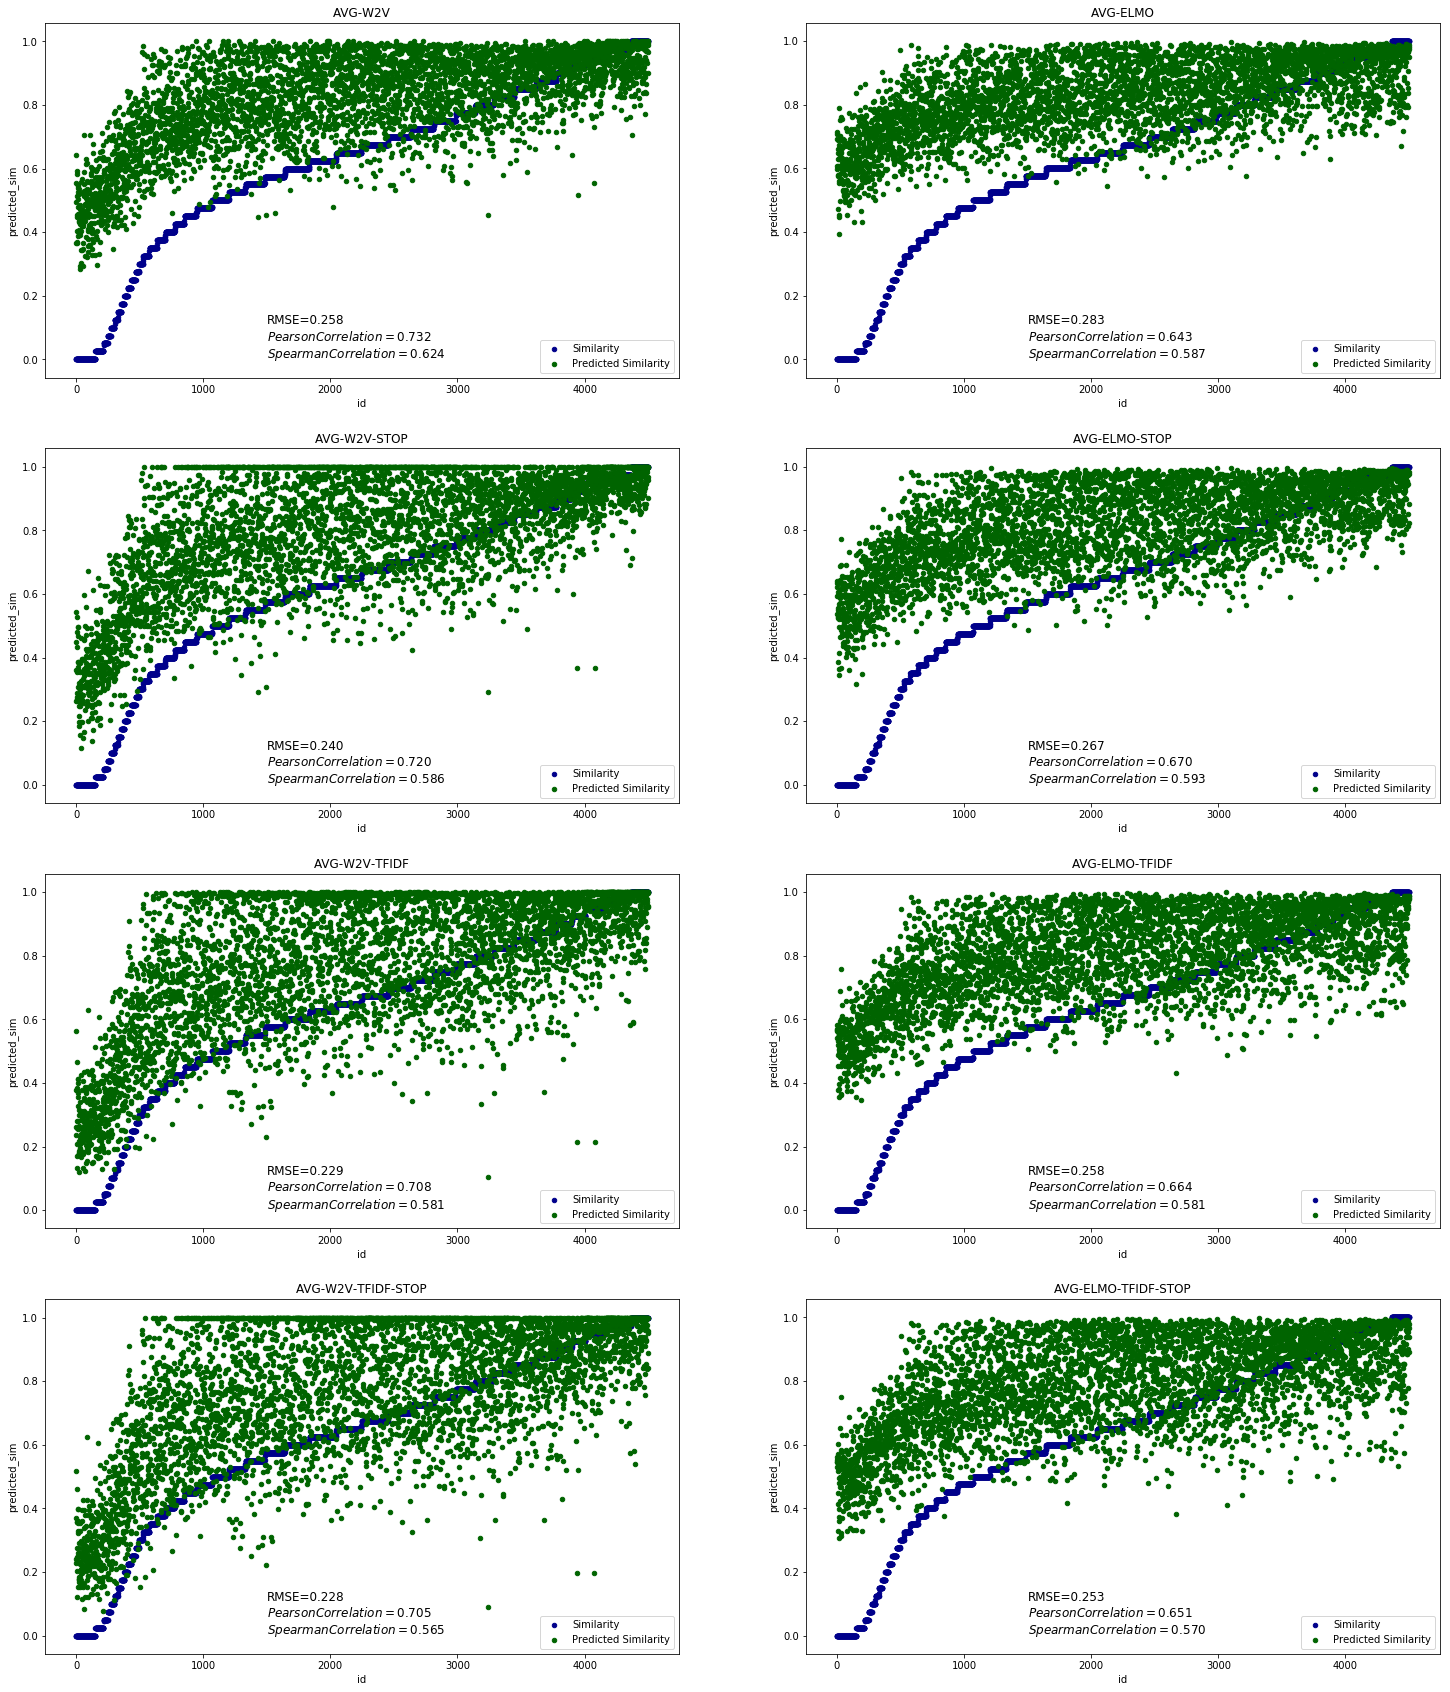

In [6]:
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,30))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 8):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    rmse = sqrt(mean_squared_error(sims, sick_train['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(1500, 0, textstr, fontsize=12)



### Smooth Inverse Frequency
Taking the average of the word embeddings in a sentence, like we did above, is a very crude method of computing sentence embeddings. Most importantly, this gives far too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem.

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by a/a+p(w), where a is a parameter that is set to 0.001 by default, and p(w) is the estimated relative frequency of a word in a reference corpus.

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc.

In [5]:
from matrices.word_vectors.smooth_inverse_frequency import run_sif_benchmark
from matrices.context_vectors.smooth_inverse_frequency import run_sif_elmo_benchmark
import functools as ft

benchmarks = [("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequency, model=word2vec, use_stoplist=False)),
              ("SIF-ELMO", ft.partial(run_sif_elmo_benchmark, freqs=frequency, model_path='ml_models/elmo/sick', use_stoplist=False))]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


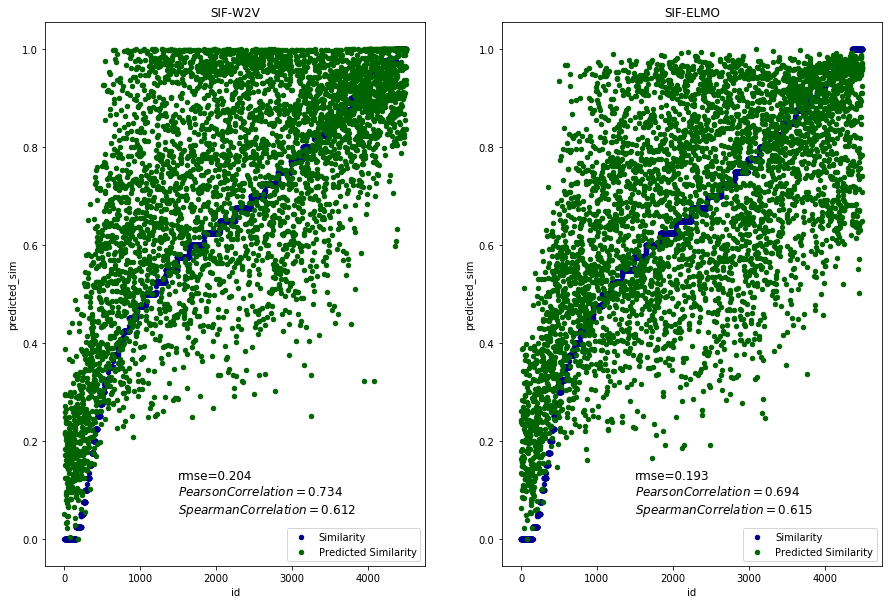

In [7]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_train['predicted_sim'], sick_train['sim']))
    textstr = 'rmse=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

In [4]:
from matrices.word_vectors.smooth_inverse_frequency import run_sif_benchmark
from matrices.context_vectors.smooth_inverse_frequency import run_sif_elmo_benchmark
import functools as ft

benchmarks = [("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequency, model=word2vec, use_stoplist=False)),
              ("SIF-ELMO", ft.partial(run_sif_elmo_benchmark, freqs=frequency, model_path='ml_models/elmo/sts', use_stoplist=False))]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


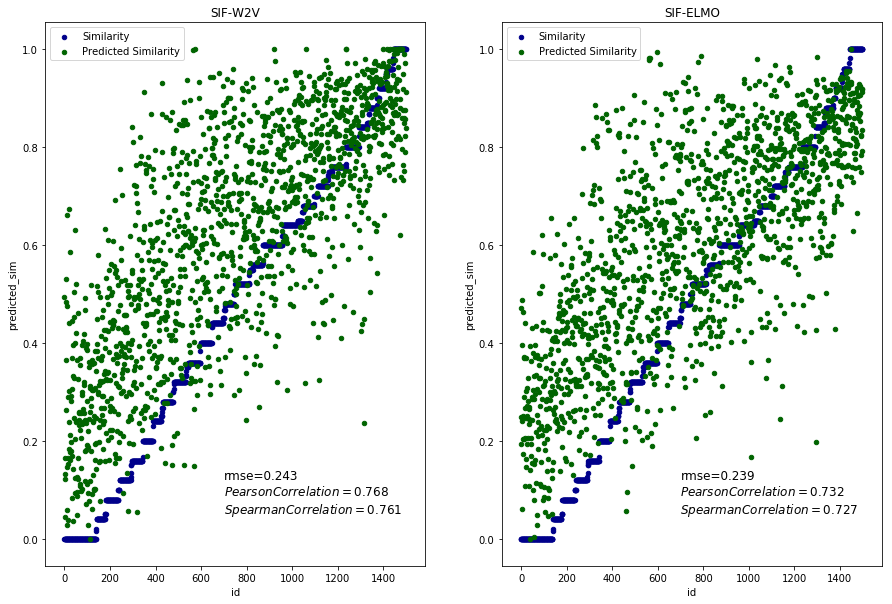

In [7]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    rmse = sqrt(mean_squared_error(sts_dev['predicted_sim'], sts_dev['sim']))
    textstr = 'rmse=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(700, 0.05, textstr, fontsize=12)

### Word Mover's Distance
Word mover's distance is a popular alternative to the simple average embedding similarity. The Word Mover's Distance uses the word embeddings of the words in two texts to measure the minimum amount that the words in one text need to "travel" in semantic space to reach the words of the other text. 

In [5]:
from matrices.word_vectors.word_movers_distance import run_wmd_benchmark
from matrices.context_vectors.word_movers_distance import run_elmo_wmd_benchmark
import functools as ft

benchmarks = [("WMD-W2V", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=False)), 
              ("WMD-ELMo", ft.partial(run_elmo_wmd_benchmark, model_path='ml_models/elmo/sick', use_stoplist=False)),
              ("WMD-W2V-STOP", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=True)),    
              ("WMD-ELMo-STOP", ft.partial(run_elmo_wmd_benchmark, model_path='ml_models/elmo/sick', use_stoplist=True))]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


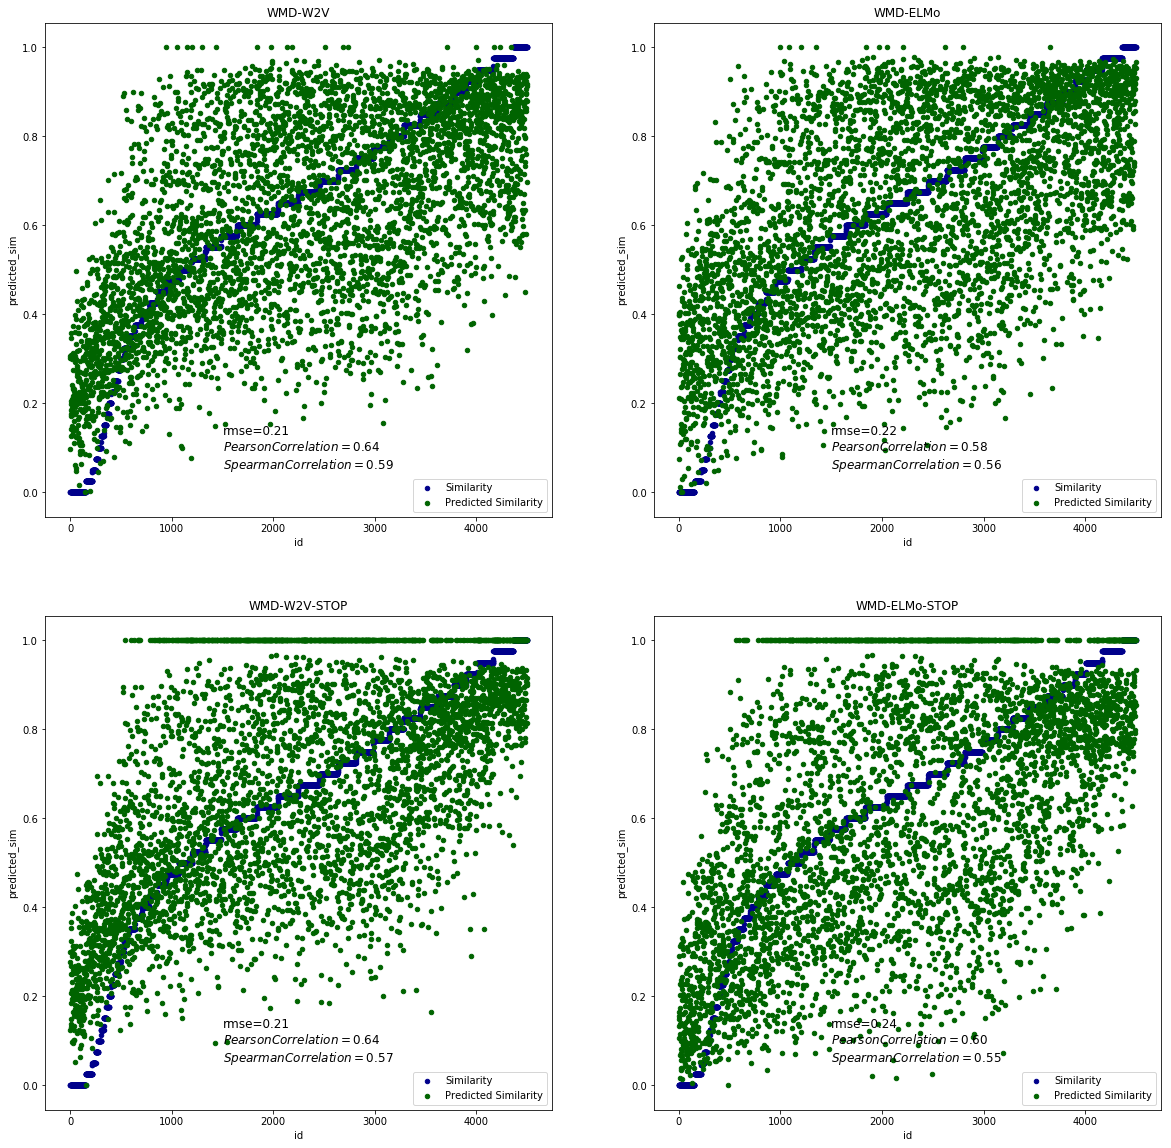

In [9]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 4):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_train['predicted_sim'], sick_train['sim']))
    textstr = 'rmse=%.2f\n$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(1500, 0.05, textstr, fontsize=12)



## Conclusions
Even though ELMo embeddings sound promising when it comes to sentence similarity task it didn't out performed most of the word2vec benchmarks. One reason might be the high dimensions in the ELMo embeddings. 

How ever in Smooth Inverse Frequency mthod ELMo embeddings outperformed word2vec embeddings - which is actually the best method we doscovered for simple sentence similarity. 